# XJTU-SY Bearing Dataset Preprocessing
This notebook preprocesses the XJTU-SY Bearing dataset stored in CSV format. It extracts cycle-wise features (RMS, max, min, std), assigns Remaining Useful Life (RUL), and saves a clean dataset for training anomaly detection and RUL prediction models.

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm


In [ ]:
def extract_features_from_file(csv_path):
    #skipping non-numeric header row (first row)
    df = pd.read_csv(csv_path, header=None, skiprows=1, engine='python')

    # Flatten and convert values to float
    values = df.values.flatten().astype(float)

    return {
        'rms': np.sqrt(np.mean(values ** 2)),
        'max': np.max(values),
        'min': np.min(values),
        'std': np.std(values)
    }


In [13]:
DATA_DIR = '../data/xjtu-sy/XJTU-SY_Bearing_Datasets'
LOAD_CONDITIONS = ['35Hz12kN', '37.5Hz11kN', '40Hz10kN']

all_records = []
for load in LOAD_CONDITIONS:
    load_path = os.path.join(DATA_DIR, load)
    bearing_folders = sorted([
    b for b in os.listdir(load_path) 
    if os.path.isdir(os.path.join(load_path, b)) and not b.startswith('.')
])

    for bearing in bearing_folders:
        bearing_path = os.path.join(load_path, bearing)
        cycle_files = sorted(os.listdir(bearing_path), key=lambda x: int(x.split('.')[0]))
        total_cycles = len(cycle_files)
        for idx, csv_file in enumerate(cycle_files):
            csv_path = os.path.join(bearing_path, csv_file)
            features = extract_features_from_file(csv_path)
            features['cycle'] = idx + 1
            features['RUL'] = total_cycles - idx
            features['bearing'] = bearing
            features['load'] = load
            all_records.append(features)


In [14]:
df_all = pd.DataFrame(all_records)
os.makedirs('../data/processed', exist_ok=True)
df_all.to_csv('../data/processed/xjtu_preprocessed.csv', index=False)
df_all.head()

,rms,max,min,std,cycle,RUL,bearing,load
0,0.562183,2.354336,-2.529883,0.562174,1,123,Bearing1_1,35Hz12kN
1,0.578076,3.195643,-3.623104,0.578035,2,122,Bearing1_1,35Hz12kN
2,0.579297,3.321779,-3.195667,0.579297,3,121,Bearing1_1,35Hz12kN
3,0.583205,2.872622,-2.692938,0.583189,4,120,Bearing1_1,35Hz12kN
4,0.593900,4.136920,-3.526568,0.593838,5,119,Bearing1_1,35Hz12kN


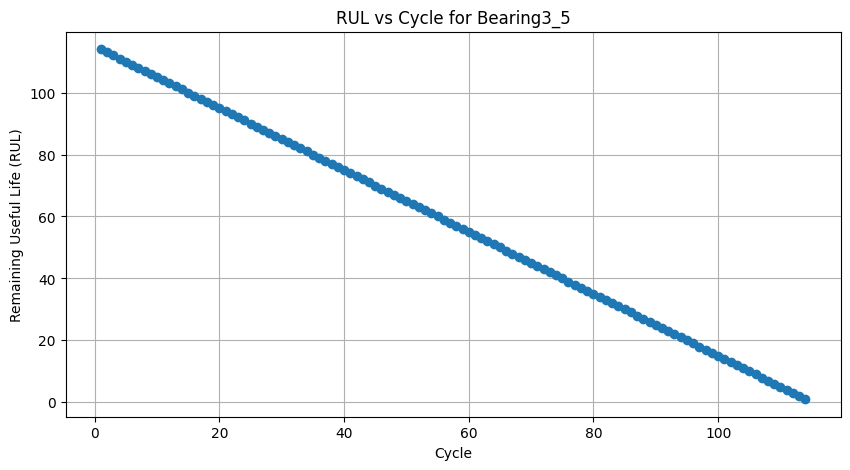

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

# Plot RUL vs cycle for a specific bearing
bearing_name = 'Bearing3_5'
bearing_df = df_all[df_all['bearing'] == bearing_name]

plt.figure(figsize=(10, 5))
plt.plot(bearing_df['cycle'], bearing_df['RUL'], marker='o')
plt.title(f'RUL vs Cycle for {bearing_name}')
plt.xlabel('Cycle')
plt.ylabel('Remaining Useful Life (RUL)')
plt.grid(True)
plt.show()
save_path = '../results/plots/xjtu_rul_plot.png'
plt.savefig(save_path, bbox_inches='tight')

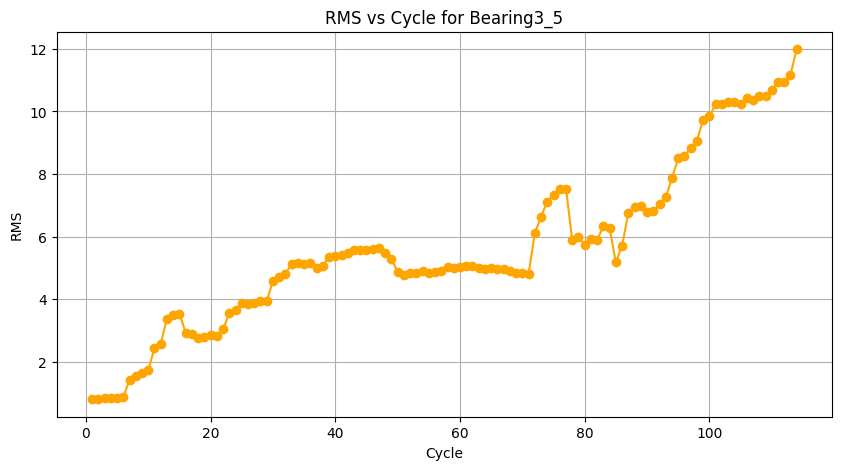

<Figure size 1200x600 with 0 Axes>

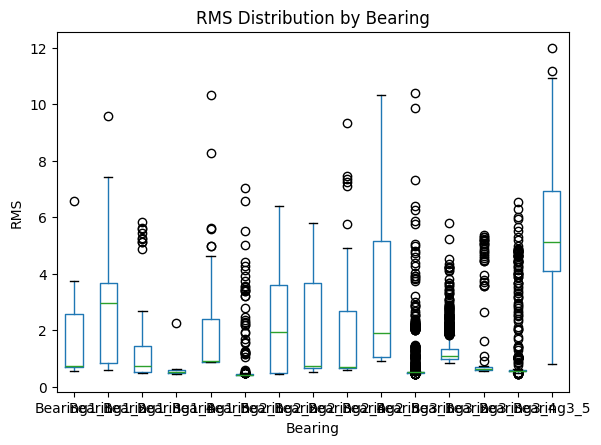

In [ ]:
# Plot RMS over cycles for the same bearing
plt.figure(figsize=(10, 5))
plt.plot(bearing_df['cycle'], bearing_df['rms'], marker='o', color='orange')
plt.title(f'RMS vs Cycle for {bearing_name}')
plt.xlabel('Cycle')
plt.ylabel('RMS')
plt.grid(True)
plt.show()

# Boxplot of RMS for all bearings
plt.figure(figsize=(12, 6))
df_all.boxplot(column='rms', by='bearing', grid=False)
plt.title('RMS Distribution by Bearing')
plt.suptitle('')
plt.xlabel('Bearing')
plt.ylabel('RMS')
plt.show()
save_path = '../results/plots/xjtu_rms_boxplot.png'